This notebook uses `sktime`


Examples of classification; try just training a CNN versus Random Weights versus raw time series?
+ Justification: TimeNet paper suggests generic feature extractors exist


https://github.com/hfawaz/dl-4-tsc/tree/master/classifiers
https://pyts.readthedocs.io/en/stable/generated/pyts.datasets.load_basic_motions.html

In [16]:
import sys

import matplotlib.pyplot as plt
import json

# import dysts
# from dysts.flows import *
# from dysts.base import *
# from dysts.utils import *
# from dysts.analysis import *

import pandas as pd
import seaborn as sns

import degas as dg
dg.set_style()

# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# %%bash

# python sweep_surrogate_transfer_learning.py

Process is terminated.


## Import experiment results

score_transfer    0.844231
score_tsfresh     0.808389
score_random      0.820000
dtype: float64


<AxesSubplot:>

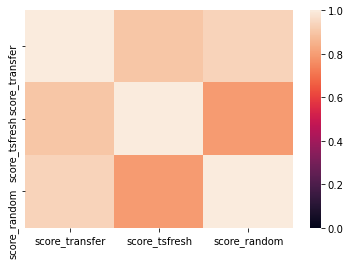

In [32]:
import json
from scipy.stats import sem 
semd = lambda x, **kwargs : 1.253 * sem(x, **kwargs)

with open("./results/transfer_learning.json", "r") as file:
    all_scores = json.load(file)
model_names = ["score_tsfresh", "score_random", "score_transfer"]

data = pd.DataFrame(all_scores).transpose()
print(data.median())

sns.heatmap(data.corr(), vmin=0, vmax=1)

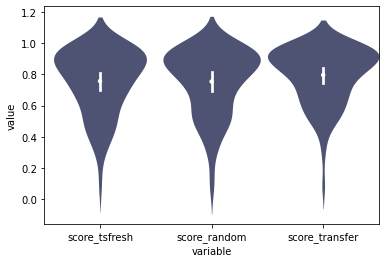

In [26]:
 
data_long = pd.melt(data, value_vars=model_names)
ax = sns.violinplot(data=data_long,  x="variable", y="value",  
              linewidth=0, size=3, alpha=0.1, split=True, 
                    width=1,
                    order=model_names,
                    scale="area", inner=None, 
                    color=[71/255., 78/255., 123/255.],
                   )
    
ax = sns.pointplot(data=data_long, x="variable", y="value", 
                   order=model_names,
              linewidth=0, 
                   size=0.1, 
                   scale = 0.5,
                   palette={ "w"}, 
                   join=False, ci=99)


<AxesSubplot:xlabel='year', ylabel='passengers'>

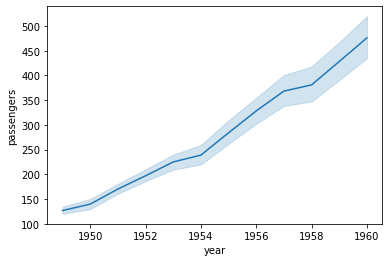

In [67]:
flights = sns.load_dataset("flights")
sns.lineplot(data=flights, x="year", y="passengers")

<AxesSubplot:xlabel='variable', ylabel='value'>

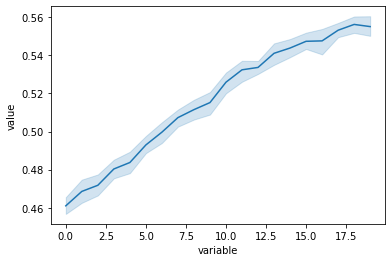

In [75]:
sns.set_style()

data = pd.DataFrame(all_vals)
data_long = pd.melt(data)

sns.lineplot(data=data_long, x="variable", y="value", palette="mako")
# sns.despine()

## Data scaling

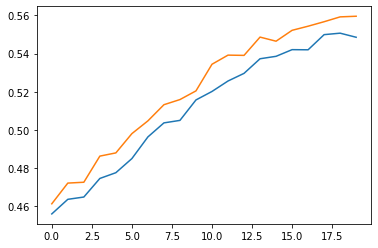

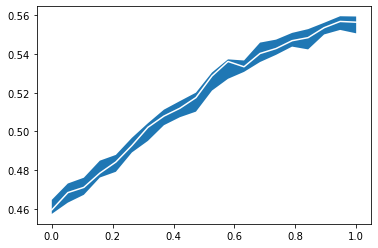

In [104]:



est_func = np.mean
all_ci = list()
for row in all_vals.T:
    
    all_estimators = list()
    for i in range(500):
        estimator = est_func(np.random.choice(row, size=all_vals.shape[0], replace=True))
        all_estimators.append(estimator)
    all_ci.append((np.percentile(all_estimators, 5), np.percentile(all_estimators, 95)))
all_ci = np.array(all_ci)

plt.fill_between(np.linspace(0, 1, len(all_ci)), all_ci[:, 0], all_ci[:, 1])
plt.plot(np.linspace(0, 1, len(all_ci)), med_vals, 'w')

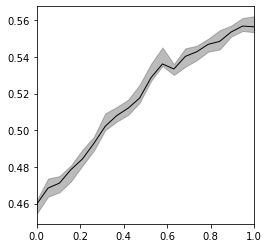

In [117]:
all_dev = np.vstack([all_ci[:, 1] - med_vals, med_vals - all_ci[:, 0]]).T

dg.plot_err(med_vals, all_dev, x=np.linspace(0, 1, len(med_vals)))
plt.xlim([0, 1])
dg.fixed_aspect_ratio(1)


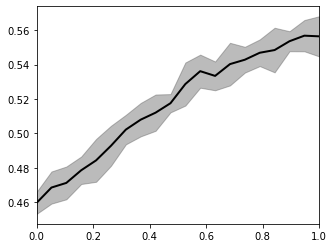

In [129]:
## plot results vs sota
from scipy.stats import sem, median_abs_deviation

semd = lambda x, **kwargs : 1.2533 * sem(x, **kwargs)

all_vals = np.loadtxt('./results/sweep_surrogate_data.csv')

med_vals = np.median(all_vals, axis=0)
dev_vals = median_abs_deviation(all_vals, axis=0, scale="normal")
# plt.plot(med_vals)
# plt.plot(med_vals + dev_vals)
# plt.plot(med_vals - dev_vals)
dg.plot_err(med_vals, dev_vals, x=np.linspace(0, 1, len(med_vals)), linewidth=2)
plt.xlim([0, 1])


dg.fixed_aspect_ratio(1/1.3)


# dg.better_savefig("../private_writing/fig_resources/data_scaling.png", dpi=600)

In [ ]:
#!/usr/bin/python3                                                                                                                                

import json
import pandas as pd
import numpy as np
import time

import pysindy as ps
from dsr import DeepSymbolicRegressor
from pysr import pysr, best_callable

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
metric_calc = lambda x0, x1 : mean_absolute_percentage_error(x0, x1, symmetric=True)

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
# from dysts.analysis import *                                                                                                                    
from dysts.analysis import sample_initial_conditions


cwd = os.path.dirname(os.path.realpath(__file__))
# cwd = "."                                                                                                                                       
# dataname = os.path.splitext(os.path.basename(os.path.split(input_path)[-1]))[0]                                                                 
output_path = cwd + "/results/symbolic_scores_sweep.json"

operator_list = [
            "cos",
            "exp",
            "sin",
            "log",
            "tanh",
            "inv(x) = 1/x",
        ]

NPROCS = 24
pysr_opts = {
    "populations" : 2 * NPROCS,
    "niterations" : 5,
#    "runtests" : False,                                                                                                                          
    "procs": NPROCS, # number of threads                                                                                                          
#    "procs": 0,                                                                                                                                  
    "delete_tempfiles" : True,
    "verbosity": 0,
    "unary_operators" : operator_list,
#    "multithreading" : True,                                                                                                                     
    "binary_operators" : ["+", "*"]
}

# get data                                                                                                                                        
with open(cwd + "/resources/symb_train_test_data.json", "r") as file:
    all_train_test = json.load(file)

try:
    with open(output_path, "r") as file:
        sym_scores = json.load(file)
except FileNotFoundError:
    sym_scores = dict()
    with open(output_path, 'w') as f:
        json.dump(sym_scores, f, indent=4)

for i, equation_name in enumerate(get_attractor_list()[100:]):

#    with open(output_path, "r") as file:                                                                                                         
#        sym_scores = json.load(file)                                                                                                             

    with open(output_path, "r") as file:
        sym_scores.update(json.load(file))

    if equation_name in sym_scores.keys():
        print(f"Entry for {equation_name} found, skipping it.", flush=True)
        continue
    print(equation_name, flush=True)


    sym_scores[equation_name] = dict()

    X_train = np.array(all_train_test[equation_name]["X_train"])
    y_train = np.array(all_train_test[equation_name]["y_train"])
    X_test = np.array(all_train_test[equation_name]["X_test"])
    y_test = np.array(all_train_test[equation_name]["y_test"])
    t_train = np.array(all_train_test[equation_name]["t_train"])
    t_test = np.array(all_train_test[equation_name]["t_test"])                                                                                                            

    ndim = min([X_test.shape[-1], y_test.shape[-1]])

    ## SINDY-poly                                                                                                                                 
    t0 = time.perf_counter()
    sym_model = ps.SINDy()
    sym_model.fit(X_train, t=t_train)
    y_test_pred = sym_model.predict(X_test)
    all_scores = list()
    for i in range(ndim):
        all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
    sym_scores[equation_name]["SINDY-poly"] = np.median(all_scores)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    sym_scores[equation_name]["SINDY-poly-time"] = elapsed

    ## SINDY-fourier basis                                                                                                                        
    t0 = time.perf_counter()
    sym_model = ps.SINDy(feature_library=ps.FourierLibrary(n_frequencies=10))
    sym_model.fit(X_train, t=t_train)
    y_test_pred = sym_model.predict(X_test)
    all_scores = list()
    for i in range(ndim):
        all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
    sym_scores[equation_name]["SINDY-fourier"] = np.median(all_scores)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    sym_scores[equation_name]["SINDY-fourier-time"] = elapsed

    ## DSR                                                                                                                                        
#    t0 = time.perf_counter()                                                                                                                     
#    all_scores = list()                                                                                                                          
#    for i in range(ndim):                                                                                                                        
#        model = DeepSymbolicRegressor(cwd + "/resources/config.json")                                                                            
#        model.fit(X_train, y_train[:, i])                                                                                                        
#        y_test_pred = model.predict(X_test)                                                                                                      
#        all_scores.append(metric_calc(y_test[:, i], y_test_pred))                                                                                
#        print("iter complete", flush=True)                                                                                                       
#    final_score = np.median(all_scores)                                                                                                          
#    sym_scores[equation_name]["DSR"] = final_score                                                                                               
#    t1 = time.perf_counter()                                                                                                                     
#    elapsed = t1 - t0                                                                                                                            
#    sym_scores[equation_name]["DSR-time"] = elapsed                                                                                              

    ## pySR                                                                                                                                        
    t0 = time.perf_counter()
    all_scores = list()
    for i in range(ndim):
        try:
            models = pysr(X_train, y_train[:, i], **pysr_opts)
            y_test_pred = best_callable(models)(X_test)
            all_scores.append(metric_calc(y_test[:, i], y_test_pred))
            print("iter complete", flush=True)
        except:
            print("bad iteration", flush=True)
    try:
        final_score = np.median(all_scores)
    except:
        final_score = None
    sym_scores[equation_name]["pySR"] = final_score
    t1 = time.perf_counter()
    elapsed = t1 - t0
    sym_scores[equation_name]["pySR-time"] = elapsed

    print(equation_name, final_score, flush=True)

    with open(output_path, "r") as file:
        sym_scores.update(json.load(file))

    sym_scores.update(curr_scores)

    with open(output_path, 'w') as f:
        json.dump(sym_scores, f, indent=4)

